In [77]:
import math
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms.functional as TF

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}") 

Using device: cuda


### Data and Operator

In [78]:
# Setup
n = 100
m = 100
dim = m * n
numSamples = 5000

# Generate singular values
X_lin = torch.linspace(-6, 6, steps=min(m, n), device=device)
alpha = 15
sigmoid_flipped = torch.exp(X_lin) / (1 + torch.exp(X_lin)) 
singular_values = 10 ** (-alpha * sigmoid_flipped)
Sigma_X = torch.diag(singular_values)

# Generate GammaX and L_X
data = torch.randn(m, m, device=device)
Q, _ = torch.linalg.qr(data)
U = Q
GammaX = U @ Sigma_X @ U.T
Sigma_X_sqrt = torch.diag(torch.sqrt(torch.diag(Sigma_X)))
L_X = U @ Sigma_X_sqrt

# Generate noise
noiseSigma = 0.05
GammaE = noiseSigma**2 * torch.eye(m, device=device)
L_E = torch.linalg.cholesky(GammaE)

# Generate forward operator
def heateq(n: int, kappa: float = 1.0, dx: float = 1.0, device=None) -> torch.Tensor:
    device = device or torch.device('cpu')
    e = torch.ones(n, device=device)
    diagonals = [-2 * e, e[:-1], e[:-1]]
    L = torch.diag(diagonals[0]) + torch.diag(diagonals[1], diagonal=1) + torch.diag(diagonals[2], diagonal=-1)
    return kappa * L / dx**2
F = heateq(n=m, kappa=1.0, dx=1.0, device=device)

# Generate data
mu_X = torch.zeros(m, 1, device=device)
Z = torch.randn(m, numSamples, device=device)
X = mu_X + L_X @ Z
E = torch.randn(m, numSamples, device=device) * noiseSigma
Y = F @ X + E
GammaY = F @ GammaX @ F.T + GammaE
L_Y = torch.linalg.cholesky(GammaY)

### Theoretical Optimizers

In [79]:
r = 25

# Theoretical Forward Optimizer
C_f = F @ L_X
U_f, S_f, Vh_f = torch.linalg.svd(C_f)
U_r_f, S_r_f, Vh_r_f = U_f[:, :r], torch.diag(S_f[:r]), Vh_f[:r, :]
C_r_f = U_r_f @ S_r_f @ Vh_r_f
M_r_f = C_r_f @ torch.linalg.pinv(L_X)

# Theoretical Inverse Optimizer
C_i = GammaX @ F.T @ torch.linalg.pinv(L_Y.T)
U_i, S_i, Vh_i = torch.linalg.svd(C_i)
U_r_i, S_r_i, Vh_r_i = U_i[:, :r], torch.diag(S_i[:r]), Vh_i[:r, :]
C_r_i = U_r_i @ S_r_i @ Vh_r_i
M_r_i = C_r_i @ torch.linalg.pinv(L_Y)

### ED Training

In [80]:
import torch.nn as nn
import torch.optim as optim

class LinearAutoencoder(nn.Module):
    def __init__(self, input_dim, bottleneck_dim):
        super().__init__()
        self.encoder = nn.Linear(input_dim, bottleneck_dim, bias=False)
        self.decoder = nn.Linear(bottleneck_dim, input_dim, bias=False)

    def forward(self, x):
        return self.decoder(self.encoder(x))

# Move training data to the correct device
X_device = X.to(device)
Y_device = Y.to(device)

# Train forward autoencoder (X → Y)
model_f = LinearAutoencoder(input_dim=m, bottleneck_dim=r).to(device)
opt_f = optim.Adam(model_f.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

for _ in range(200):
    model_f.train()
    opt_f.zero_grad()
    loss = loss_fn(model_f(X_device.T), Y_device.T)
    loss.backward()
    opt_f.step()

with torch.no_grad():
    A_learned_f = model_f.decoder.weight @ model_f.encoder.weight

# Train inverse autoencoder (Y → X)
model_i = LinearAutoencoder(input_dim=m, bottleneck_dim=r).to(device)
opt_i = optim.Adam(model_i.parameters(), lr=1e-3)

for _ in range(200):
    model_i.train()
    opt_i.zero_grad()
    loss = loss_fn(model_i(Y_device.T), X_device.T)
    loss.backward()
    opt_i.step()

with torch.no_grad():
    A_learned_i = model_i.decoder.weight @ model_i.encoder.weight

### Rank Sweep

In [81]:
ranks = list(range(25, n - 24, 25))
num_epochs = 200
lr = 1e-3

# Prepare results storage
results = {
    'forward': {'theory': [], 'learned': []},
    'inverse': {'theory': [], 'learned': []}
}

# Precompute SVDs of theoretical operators
# Forward operator SVD
C_f = F @ L_X
U_f, S_f, Vh_f = torch.linalg.svd(C_f)

# Inverse operator SVD
C_i = GammaX @ F.T @ torch.linalg.pinv(L_Y.T)
U_i, S_i, Vh_i = torch.linalg.svd(C_i)

# Loop over ranks
for r in ranks:
    if r % 100 == 0: print(f"\nRank {r}")
    # --- Forward Case ---
    # Truncate SVD
    U_r_f = U_f[:, :r]
    S_r_f = torch.diag(S_f[:r])
    Vh_r_f = Vh_f[:r, :]
    C_r_f = U_r_f @ S_r_f @ Vh_r_f
    
    # Optimal forward mapping
    M_r_f = C_r_f @ torch.linalg.pinv(L_X)
    diffs_opt_f = M_r_f @ X_device - Y_device
    results['forward']['theory'].append(torch.norm(diffs_opt_f, dim=0).mean().item())

    # Train forward autoencoder
    ae_f = LinearAutoencoder(m, r).to(device)
    opt_f = optim.Adam(ae_f.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    for _ in range(num_epochs):
        opt_f.zero_grad()
        out_f = ae_f(X_device.T)
        loss_fn(out_f, Y_device.T).backward()
        opt_f.step()
    with torch.no_grad():
        A_f = ae_f.decoder.weight @ ae_f.encoder.weight
        diffs_learn_f = A_f @ X_device - Y_device
        results['forward']['learned'].append(torch.norm(diffs_learn_f, dim=0).mean().item())

    # --- Inverse Case ---
    # Truncate SVD
    U_r_i = U_i[:, :r]
    S_r_i = torch.diag(S_i[:r])
    Vh_r_i = Vh_i[:r, :]
    C_r_i = U_r_i @ S_r_i @ Vh_r_i
    
    # Optimal inverse mapping
    M_r_i = C_r_i @ torch.linalg.pinv(L_Y)
    diffs_opt_i = M_r_i @ Y_device - X_device
    results['inverse']['theory'].append(torch.norm(diffs_opt_i, dim=0).mean().item())

    # Train inverse autoencoder
    ae_i = LinearAutoencoder(m, r).to(device)
    opt_i = optim.Adam(ae_i.parameters(), lr=lr)
    for _ in range(num_epochs):
        opt_i.zero_grad()
        out_i = ae_i(Y_device.T)
        loss_fn(out_i, X_device.T).backward()
        opt_i.step()
    with torch.no_grad():
        A_i = ae_i.decoder.weight @ ae_i.encoder.weight
        diffs_learn_i = A_i @ Y_device - X_device
        results['inverse']['learned'].append(torch.norm(diffs_learn_i, dim=0).mean().item())

Forward Case
Inverse Case
Forward Case
Inverse Case
Forward Case
Inverse Case

Rank 100
Forward Case
Inverse Case
Forward Case
Inverse Case
Forward Case
Inverse Case
Forward Case
Inverse Case

Rank 200
Forward Case
Inverse Case
Forward Case
Inverse Case
Forward Case
Inverse Case
Forward Case
Inverse Case

Rank 300
Forward Case
Inverse Case
Forward Case
Inverse Case
Forward Case
Inverse Case
Forward Case
Inverse Case

Rank 400
Forward Case
Inverse Case
Forward Case
Inverse Case
Forward Case
Inverse Case
Forward Case
Inverse Case

Rank 500
Forward Case
Inverse Case
Forward Case
Inverse Case
Forward Case
Inverse Case
Forward Case
Inverse Case

Rank 600
Forward Case
Inverse Case
Forward Case
Inverse Case
Forward Case
Inverse Case
Forward Case
Inverse Case

Rank 700
Forward Case
Inverse Case
Forward Case
Inverse Case
Forward Case
Inverse Case
Forward Case
Inverse Case

Rank 800
Forward Case
Inverse Case
Forward Case
Inverse Case
Forward Case
Inverse Case
Forward Case
Inverse Case

Rank 900


KeyboardInterrupt: 

### Plotting Results

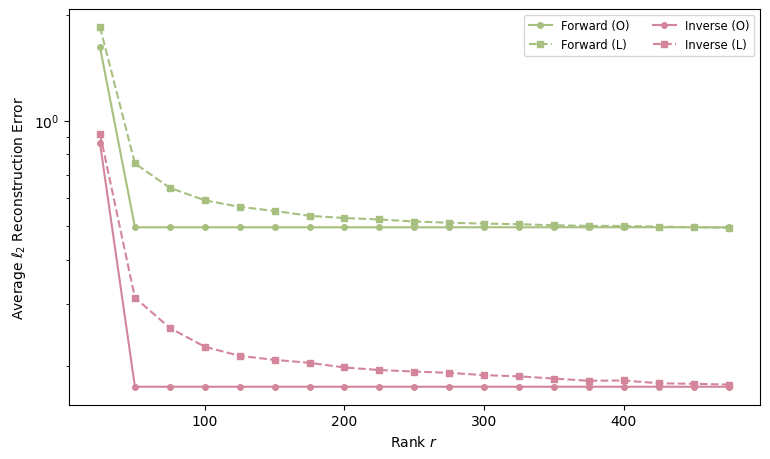

In [ ]:
# pastel‑Everforest colours 
ef_pastel   = ['#a7c080', '#d3869b', "#83c0c0", '#e69875', '#a988b0', "#b8912f"]
line_styles = {'theory': '-',  'learned': '--'}
markers     = {'theory': 'o',  'learned': 's'}
lw, ms      = 1.5, 4

# combined forward/inverse plot
plt.figure(figsize=(7.8, 4.7))
modes = ['forward', 'inverse']
short_label = {'theory': 'O', 'learned': 'L'}

for i, mode in enumerate(modes):
    col = ef_pastel[i]
    for kind in ('theory', 'learned'):
        plt.plot(
            ranks,
            results[mode][kind],
            line_styles[kind],
            marker=markers[kind],
            color=col,
            lw=lw,
            ms=ms,
            label=f"{mode.capitalize()} ({short_label[kind]})"
        )

plt.xlabel('Rank $r$')
plt.ylabel(r'Average $\ell_2$ Reconstruction Error')
plt.yscale('log')
plt.legend(ncol=2, fontsize='small')
plt.tight_layout()
# plt.savefig("synthetic_forward_inverse_ranksweep.png")
plt.show()